## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [4]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt


# -------------------- Globals ---------------------------

# all signals were sampled at 125 Hz
FS = 125 

# the number of samples in each window that will get used to compute a heartrate
WIN_SAMPLES = 1536 

# min and max beats per second for heatrate
# (this is used for the bandpass filter)
min_bps, max_bps = 40/60, 240/60 



# --------------------------------------------------------



def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals, along with an array of times in seconds
    """
    data = sp.io.loadmat(data_fl)['sig']
    ts = np.arange(0,data.shape[1] / FS, 1./FS)
    return np.vstack((data[2:],ts.reshape(1,-1)))

def LoadTroikaRefFile(ref_fl):
    """
    Loads heartrate reference from reference data file.
    These are the files named REF_*.mat, which are
    ground truth heartrate in bpm derived from EKG data.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ref_bpm = LoadTroikaDataFile(ref_fls[0])

    Args:
        ref_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy array for reference heartrate, and a numpy array for associated timestamps in seconds
    """
    ref_bpm = sp.io.loadmat(ref_fl)['BPM0'].T
    ref_ts = np.arange(4., ref_bpm.shape[1]*2+4,2.)
    return np.vstack((ref_bpm,ref_ts.reshape(1,-1)))


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def BandpassFilter(signal, pass_band=(min_bps, max_bps), fs=FS):
    """
    Bandpass filter a signal; this is copied from the exploration notebooks.
    
    Args:
        signal: a numpy array of the signal
        pass_band: array_like; a length-2 sequence giving the critical frequencies
        fs: sample rate
    
    Returns:
        Bandpass filtered signal (still in time domain, or whatever was the original domain)
    """
    b, a = sp.signal.butter(5, pass_band, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def choose_ppg_peak(ppg_fft, ppg_peaks, acc_peaks, tolerance):
    """
    Choose a preferred peak index given the fft of a ppg and an ordered list of ppg and accelerometer peaks.
    
    Args:
        ppg_fft: (numpy array) the absolute value of the fft of the ppg signal
        ppg_peaks: (numpy array) a list of ppg peaks ordered by descending importance.
                   Here "importance" is intentionally vague. It can be any reasonable metric.
        acc_peaks: (numpy array) a list of accelerometer peaks ordered by descending importance
        tolerance: (float) the distance in frequency samples such that a ppg peak index
                   and an accelerometer peak index that are within that distance would be
                   considered to be uncomfortably close. The algorithm will somewhat try to 
                   avoid choosing a ppg peak index that is too close to an accelerometer peak index.
    
    
    
    Returns:
        The index (not frequency!) of the chosen peak in the ppg fft
    """
    
    # if there are no peaks in the list, fall back to just giving argmax
    if len(ppg_peaks)==0:
        return ppg_fft.argmax()
    
    # if there is just one peak in the list, pick that one
    if len(ppg_peaks)==1:
        return ppg_peaks[0]
    
    # now if there are at least two peaks...
    
    # if the top choice is not close any of the accelerometer peaks, then choose that
    if np.all(np.abs(acc_peaks - ppg_peaks[0]) > tolerance):
        return ppg_peaks[0]
    
    # otherwise if the second choice is not close to any of the acc peaks, then choose that:
    if np.all(np.abs(acc_peaks - ppg_peaks[1]) > tolerance):
        return ppg_peaks[1]
    
    # otherwise if there's no third option, or if the third option is no better at staying
    # away from acc peaks, then fall back to the original top choice
    if len(ppg_peaks) < 3 or np.all(np.abs(acc_peaks - ppg_peaks[2]) <= tolerance):
        return ppg_peaks[0]
    
    # finally, if there is a third option and it does stay away from acc peaks, then choose that:
    return ppg_peaks[2]

def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Run the pulse rate algorithm on the given .mat data and reference files, returning errors and confidences.
    
    Args:
        data_fl: Names of the .mat file that contains signal data
        ref_fl: Names of the .mat file that contains reference data
        
    Returns:
        errors: a numpy array of absolute differences between the ground truth
                and the predicted heartrates, in beats per minute
        confidences: a numpy array of confidence values for each prediction
    """
    
    # Load data using LoadTroikaDataFile
    ref_bpm, ref_ts = LoadTroikaRefFile(ref_fl)
    ppg, accx, accy, accz, ts = LoadTroikaDataFile(data_fl)
    
    # magnitude of acceleration
    acc = np.sqrt(accx**2 + accy**2 + accz**2)
    
    # run bandpass filter
    ppg_filtered = BandpassFilter(ppg)
    acc_filtered = BandpassFilter(acc)
    
    # loop over windows of size WIN_SAMPLES samples, in 2 second increments
    errors, confidences = [], []
    for i in range(0,len(ppg_filtered)-WIN_SAMPLES, 2*FS):
        
        # Compute absolute value of ffts
        ppg_fft = np.abs(np.fft.rfft(ppg_filtered[i:i+WIN_SAMPLES]))
        acc_fft = np.abs(np.fft.rfft(acc_filtered[i:i+WIN_SAMPLES]))
        freqs = np.fft.rfftfreq(WIN_SAMPLES,1/FS)
        freq_sample_rate = len(freqs)/freqs[-1] # in samples per Hz

        # Crop the ffts and freqs array to the band we care about
        band_mask = (freqs >= min_bps) & (freqs <= max_bps)
        freqs = freqs[band_mask]
        acc_fft = acc_fft[band_mask]
        ppg_fft = ppg_fft[band_mask]

         

        # find peaks in the ppg and fft frequency domain; sort descending by prominence
        ppg_peaks, ppg_peak_properties = sp.signal.find_peaks(ppg_fft, prominence=10000, wlen=freq_sample_rate*0.65, distance=0.1*freq_sample_rate)
        ppg_peaks = list(map(lambda x:x[0], sorted(zip(ppg_peaks, ppg_peak_properties['prominences']), key=lambda x:x[1], reverse=True)))
        acc_peaks, acc_peak_properties = sp.signal.find_peaks(acc_fft, prominence=10000/400, wlen=freq_sample_rate*1., distance=0.2*freq_sample_rate)
        acc_peaks = list(map(lambda x:x[0], sorted(zip(acc_peaks, acc_peak_properties['prominences']), key=lambda x:x[1], reverse=True)))

        # apply algorithm to choose a preferred peak index
        peak_index = choose_ppg_peak(ppg_fft, ppg_peaks, acc_peaks, 0.1 * freq_sample_rate)
                
        # attenuate ppg amplitudes based on accelerometer amplitudes; used for computing confidence
        attenuation_param = acc_fft.max()/3
        ppg_fft_attenuated = ppg_fft * (attenuation_param/(attenuation_param+acc_fft))
        
        # compute confidence
        window_half_width = freq_sample_rate * 0.14  # in frequency samples
        confidence = ppg_fft_attenuated[int(round(peak_index - window_half_width)):int(round(peak_index + window_half_width))].sum()/ppg_fft_attenuated.sum()
        
        # the ground truth beats per second, at midpoint of interval
        ekg_bps = np.interp(ts[i+WIN_SAMPLES//2],ref_ts,ref_bpm) / 60.
        
        # compute error, convert back to bpm
        error = np.abs(freqs[peak_index] - ekg_bps) * 60.
        
        errors.append(error)
        confidences.append(confidence)
        

    # Compute pulse rate estimates and estimation confidence.

    # Return absolute errors and confidences as a 2-tuple of numpy arrays.
    errors, confidences = map(np.array, (errors,confidences))
    return errors, confidences

# Data Exploration

(Many of the following cells aided the writing of the algorithms above)

In [5]:
data_fls, ref_fls = LoadTroikaDataset()

# The duration in minutes for each subject
[LoadTroikaDataFile(data_fl).shape[1] / FS / 60. for data_fl in data_fls]

[5.0582666666666665,
 5.046666666666667,
 4.798533333333333,
 3.6768,
 4.966666666666667,
 4.977066666666667,
 5.1164,
 4.886666666666667,
 5.4403999999999995,
 5.072266666666667,
 4.866666666666666,
 4.975466666666667]

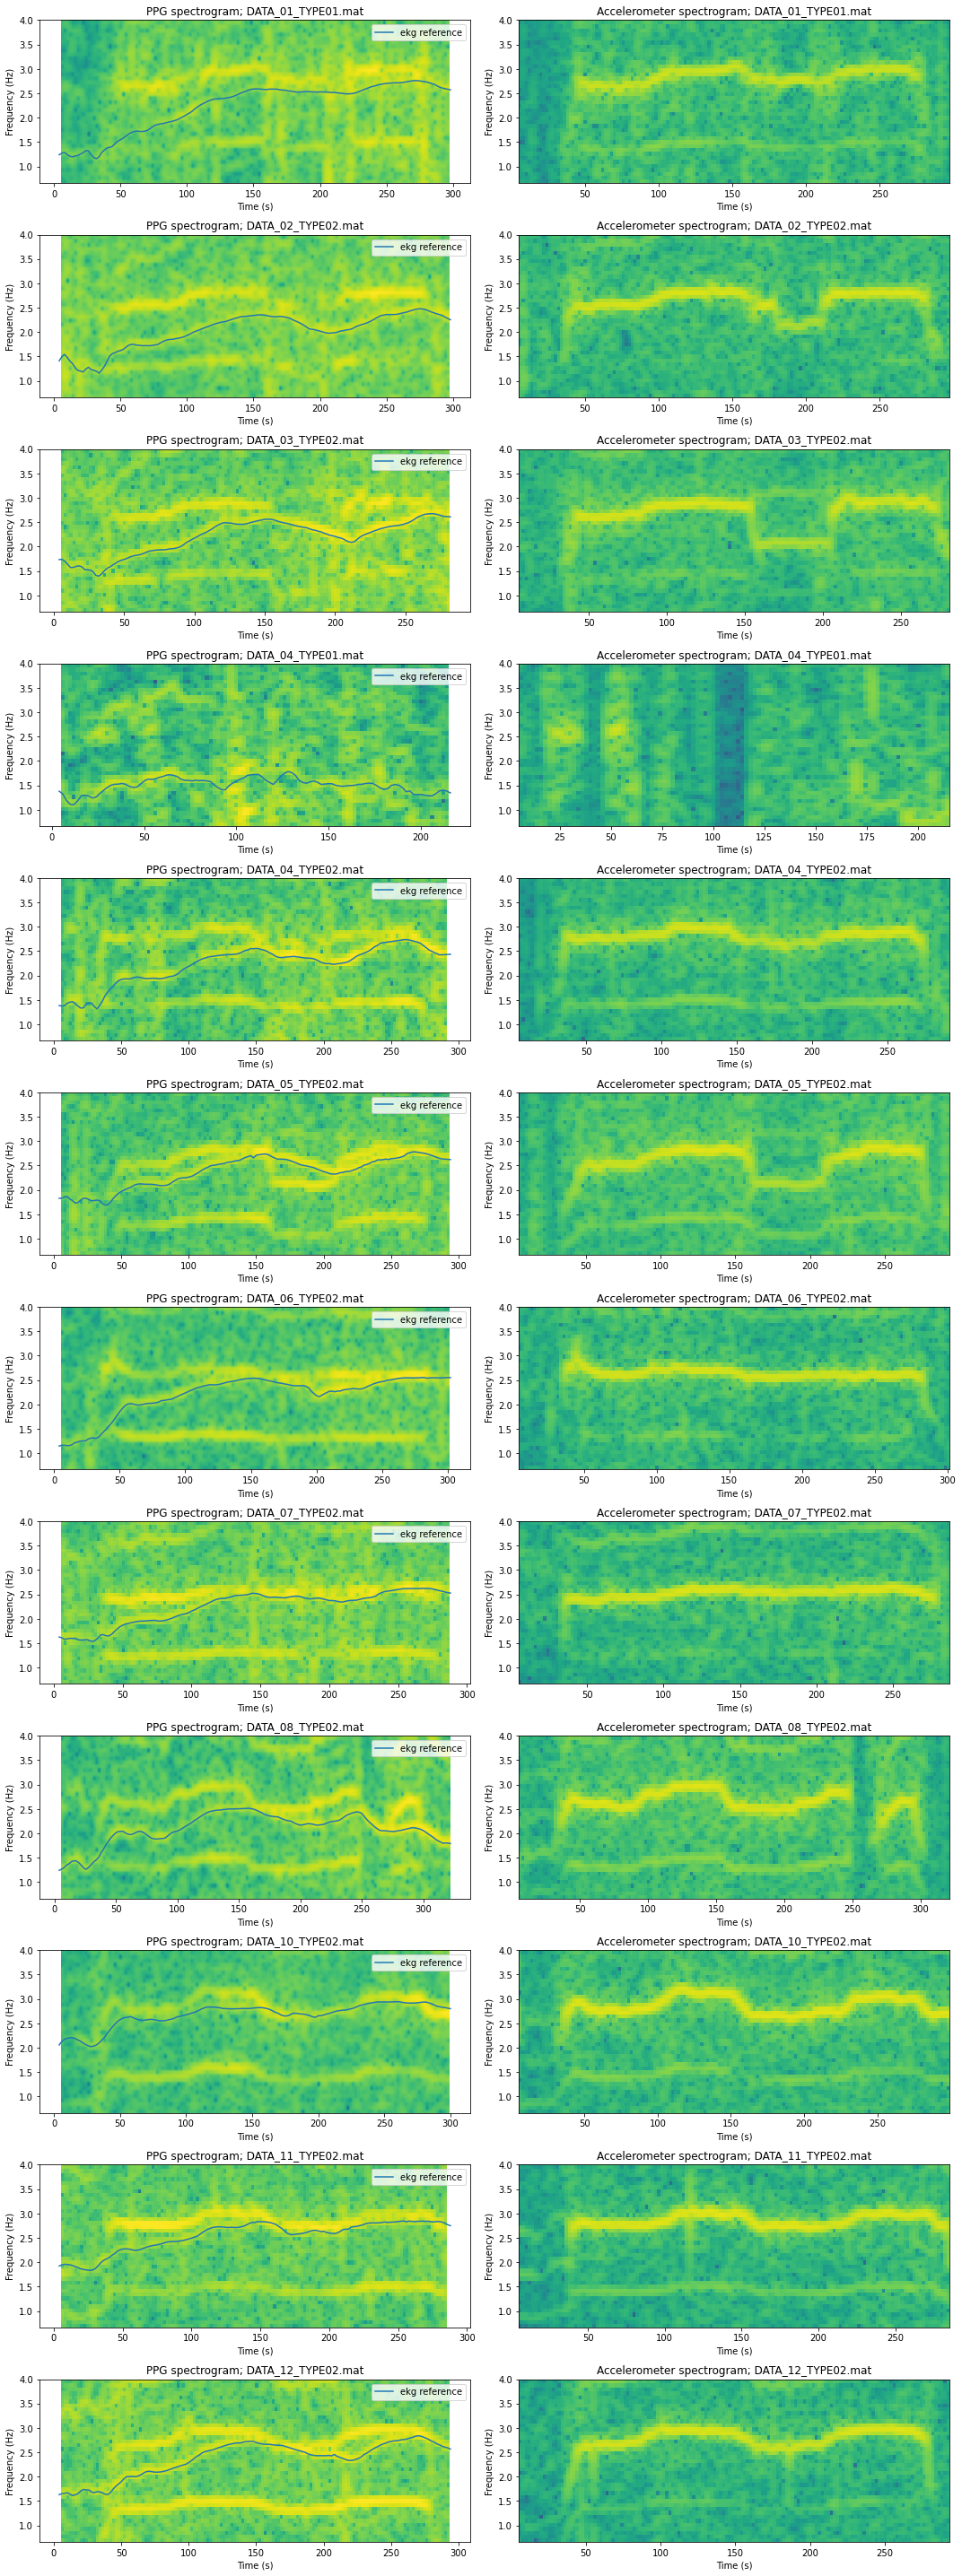

In [6]:
# spectrograms of the unfiltered data, with the reference heartrate superimposed on top
fig, axs = plt.subplots(len(data_fls), 2, figsize=(15,40))
for axrow, data_fl, ref_fl in zip(axs, data_fls, ref_fls):
    ax1, ax2 = axrow
    ppg, accx, accy, accz, ts = LoadTroikaDataFile(data_fl)
    acc = np.sqrt(accx**2 + accy**2 + accz**2)
    ref_bpm, ref_ts = LoadTroikaRefFile(ref_fl)

    ax1.specgram(x=ppg,Fs=FS, NFFT=WIN_SAMPLES, noverlap=WIN_SAMPLES-2*FS)
    ax1.plot(ref_ts,ref_bpm/60., label='ekg reference')
    ax1.set_title("PPG spectrogram; " + data_fl.split('/')[-1])
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Frequency (Hz)')
    ax1.set_ylim(min_bps, max_bps)
    ax1.legend()
    
    ax2.specgram(x=acc,Fs=FS, NFFT=WIN_SAMPLES, noverlap=WIN_SAMPLES-2*FS)
    ax2.set_title("Accelerometer spectrogram; " + data_fl.split('/')[-1])
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Frequency (Hz)')
    ax2.set_ylim(min_bps, max_bps)
    
    
    
fig.tight_layout()
plt.show()

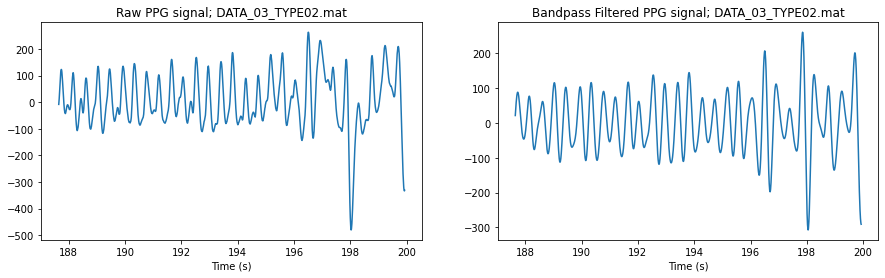

In [7]:
# plot random chunk of data, view unfiltered and filtered
# run this cell many times to explore

data_fl = data_fls[np.random.randint(0,len(data_fls))]
ppg, accx, accy, accz, ts = LoadTroikaDataFile(data_fl)
ppg_filtered = BandpassFilter(ppg)
i = np.random.randint(0,len(ts)-WIN_SAMPLES)
j = i + WIN_SAMPLES
fig, axs = plt.subplots(1,2,figsize=(15,4))
ax1,ax2=axs
ax1.plot(ts[i:j], ppg[i:j])
ax1.set_title('Raw PPG signal; '+data_fl.split('/')[-1])
ax1.set_xlabel('Time (s)')
ax2.plot(ts[i:j], ppg_filtered[i:j])
ax2.set_title('Bandpass Filtered PPG signal; '+data_fl.split('/')[-1])
ax2.set_xlabel('Time (s)')
plt.show()

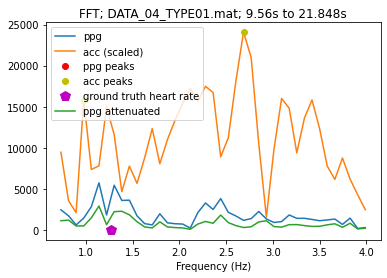

1.1393229166666665
0.1668790909969925
0.13280635000000007


In [8]:
# plot FTTs in a random chunk of filtered data
# run this cell many times to explore

rand_index = np.random.randint(0,len(data_fls))
data_fl, ref_fl = data_fls[rand_index], ref_fls[rand_index]
ref_bpm, ref_ts = LoadTroikaRefFile(ref_fl)
ppg, accx, accy, accz, ts = LoadTroikaDataFile(data_fl)
acc = np.sqrt(accx**2 + accy**2 + accz**2)
ppg_filtered = BandpassFilter(ppg)
acc_filtered = BandpassFilter(acc)
i=np.random.randint(0,len(ppg_filtered)-WIN_SAMPLES)
ppg_fft = np.abs(np.fft.rfft(ppg_filtered[i:i+WIN_SAMPLES]))
acc_fft = np.abs(np.fft.rfft(acc_filtered[i:i+WIN_SAMPLES]))
freqs = np.fft.rfftfreq(WIN_SAMPLES,1/FS)
freq_sample_rate = len(freqs)/freqs[-1] # in samples per Hz

# Crop the ffts and freqs array to the band we care about
band_mask = (freqs >= min_bps) & (freqs <= max_bps)
freqs = freqs[band_mask]
acc_fft = acc_fft[band_mask]
ppg_fft = ppg_fft[band_mask]


# the ground truth beats per second at midpoint of interval
ekg_bps = np.interp(ts[i+WIN_SAMPLES//2],ref_ts,ref_bpm) / 60. 

ppg_peaks, ppg_peak_properties = sp.signal.find_peaks(ppg_fft, prominence=10000, wlen=freq_sample_rate*0.65, distance=0.1*freq_sample_rate)
ppg_peaks = list(map(lambda x:x[0], sorted(zip(ppg_peaks, ppg_peak_properties['prominences']), key=lambda x:x[1],reverse=True)))

acc_peaks, acc_peak_properties = sp.signal.find_peaks(acc_fft, prominence=10000/400, wlen=freq_sample_rate*1., distance=0.2*freq_sample_rate)
acc_peaks = list(map(lambda x:x[0], sorted(zip(acc_peaks, acc_peak_properties['prominences']), key=lambda x:x[1],reverse=True)))

plt.plot(freqs,ppg_fft,label='ppg')
plt.plot(freqs,400*acc_fft,label='acc (scaled)')
# plt.xlim(min_bps,max_bps)
plt.xlabel('Frequency (Hz)')
plt.title('FFT; {}; {}s to {}s'.format(data_fl.split('/')[-1], i/FS, (i+WIN_SAMPLES)/FS))
plt.plot(freqs[ppg_peaks], ppg_fft[ppg_peaks], 'r.', markersize=12, label='ppg peaks')
plt.plot(freqs[acc_peaks], 400*acc_fft[acc_peaks], 'y.', markersize=12, label='acc peaks')
plt.plot(ekg_bps,0,'mp',markersize=10, label='ground truth heart rate')

# attenuate ppg amplitudes based on accelerometer amplitudes
attenuation_param = acc_fft.max()/3
ppg_fft_attenuated = ppg_fft * (attenuation_param/(attenuation_param+acc_fft))
plt.plot(freqs, ppg_fft_attenuated, label='ppg attenuated')

plt.legend()
plt.show()

peak_index = choose_ppg_peak(ppg_fft, ppg_peaks, acc_peaks, 0.1 * freq_sample_rate)
print(freqs[peak_index])

window_half_width = freq_sample_rate * 0.14  # in frequency samples
confidence = ppg_fft_attenuated[int(round(peak_index - window_half_width)):int(round(peak_index + window_half_width))].sum()/ppg_fft_attenuated.sum()
print(confidence)
error = np.abs(freqs[peak_index] - ekg_bps)
print(error)

In [10]:
Evaluate()

20.011265977045355

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 